## Importation des bibliothèques et modules nécessaires


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
import transformers
from transformers import BertTokenizer, TFBertModel

c:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


### Chargement et exploration initiale du dataset


In [2]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.shape

(5572, 5)

### Suppression de colonnes inutiles

- **Suppression de colonnes** : Les colonnes `"Unnamed: 2"`, `"Unnamed: 3"` et `"Unnamed: 4"` sont supprimées du DataFrame `df` car elles sont jugées inutiles pour l'analyse.


In [5]:
df = df.drop([ "Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis = 1)

In [6]:
df.head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Renommage des colonnes

- **Renommage des colonnes** : 
  - La colonne `v1` est renommée en `Class` pour indiquer la classe des messages (par exemple, spam ou ham).
  - La colonne `v2` est renommée en `Text` pour représenter le contenu textuel des messages.

In [7]:
df.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Analyse de la distribution des longueurs des messages


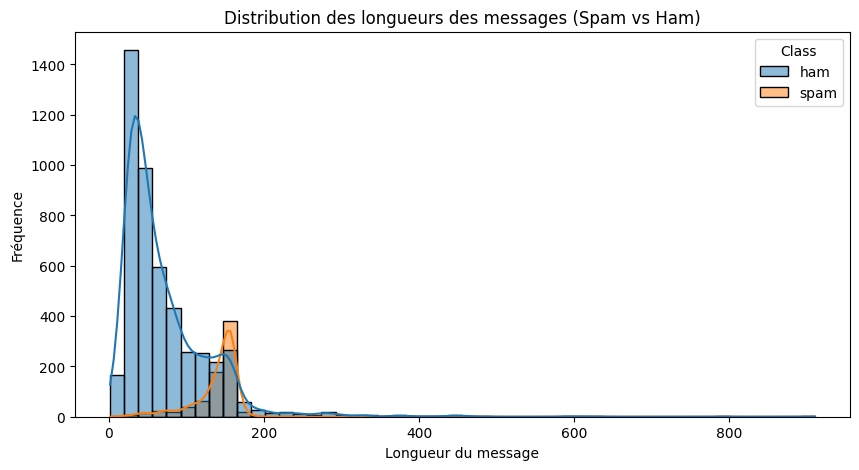

In [8]:
df['Length'] = df['Text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Length', hue='Class', bins=50, kde=True)
plt.title('Distribution des longueurs des messages (Spam vs Ham)')
plt.xlabel('Longueur du message')
plt.ylabel('Fréquence')
plt.show()


- Le graphique ci-dessus montre la **distribution des longueurs des messages** en fonction de leur classe (`Spam` ou `Ham`).
- **Observation** :
  - Les messages classés comme `Ham` (non-spam) ont tendance à être plus courts.
  - Les messages classés comme `Spam` présentent une concentration différente avec des longueurs généralement plus élevées.

### Visualisation de la répartition des classes  (`Spam` vs `Ham`)


<Axes: xlabel='Class'>

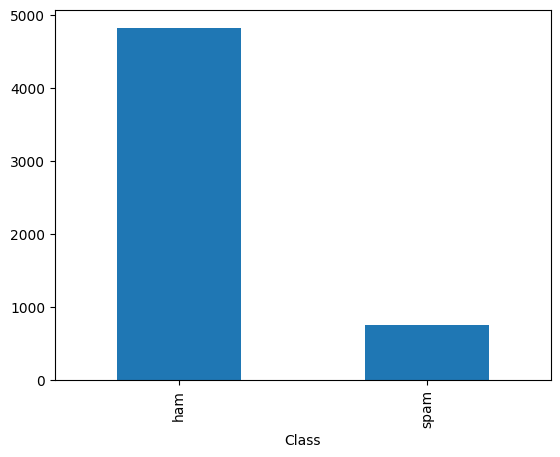

In [9]:
df['Class'].value_counts().plot(kind = 'bar')

- Le graphique en barres ci-dessus montre la distribution des classes dans le dataset :
  - `Ham` est largement majoritaire.
  - `Spam` est en proportion bien plus faible.


### Encodage des classes et résumé statistique du dataset

- **Encodage des classes** :
  - La colonne `Class` est transformée en valeurs numériques :
    - `ham` est mappé à `0` (représentant les messages non-spam).
    - `spam` est mappé à `1` (représentant les messages indésirables).

In [10]:
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text,Length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [11]:
df.describe()

,Class,Length
count,5572.000000,5572.000000
mean,0.134063,80.118808
std,0.340751,59.690841
min,0.000000,2.000000
25%,0.000000,36.000000
50%,0.000000,61.000000
75%,0.000000,121.000000
max,1.000000,910.000000


### Création de nuages de mots pour les messages Ham et Spam


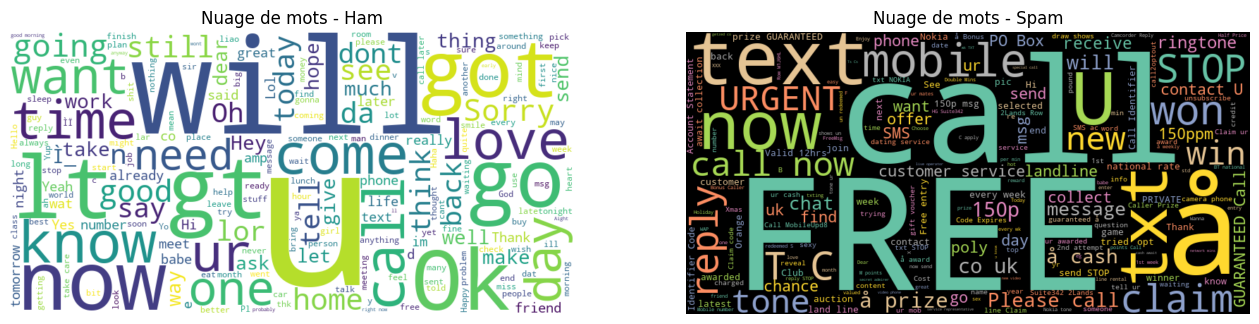

In [13]:
from wordcloud import WordCloud

ham_words = " ".join(df[df['Class'] == 0]['Text'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

spam_words = " ".join(df[df['Class'] == 1]['Text'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(spam_words)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Nuage de mots - Ham")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Nuage de mots - Spam")
plt.axis("off")

plt.show()


- **Nuage de mots pour les messages `Ham`** (à gauche) :
  - Représente les mots les plus fréquents dans les messages non-spam.
  - Les mots comme "will", "time", "good", "day", et "know" ressortent comme récurrents dans cette catégorie.

- **Nuage de mots pour les messages `Spam`** (à droite) :
  - Met en évidence les mots typiques des messages indésirables.
  - Les termes comme "call", "FREE", "claim", "mobile", et "URGENT" apparaissent fréquemment, reflétant le langage promotionnel ou frauduleux.

- **Comparaison** :
  - Les messages `Ham` contiennent des mots usuels, souvent liés à des conversations personnelles.
  - Les messages `Spam` utilisent des mots spécifiques pour inciter à l'action ou à la réponse.

### Téléchargement des ressources NLTK nécessaires


In [14]:
import nltk

nltk.download('stopwords')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\celia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Importation des outils de traitement linguistique NLTK


In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

### Configuration des stopwords et initialisation du stemming


- **Liste des mots vides (`stop_words`)** :
  - Utilisation de la fonction `stopwords.words('english')` pour récupérer les mots vides en anglais.

- **Initialisation du stemmer (`porter`)** :
  - Création d'une instance de `PorterStemmer`, un algorithme permettant de réduire les mots à leur racine (exemple : "running" → "run").

In [16]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


### Prétraitement des textes : nettoyage, suppression des stopwords et stemming

- **`clean_text`** : Nettoie le texte en supprimant les caractères non alphabétiques et en mettant tout en minuscule.
- **`remove_stopwords`** : Supprime les mots vides (stopwords) du texte.
- **`stemmer`** : Réduit les mots à leur racine avec l'algorithme de stemming.

- **Application des fonctions** : Ces transformations sont appliquées à la colonne `Text` du DataFrame pour préparer les données textuelles.



In [17]:
def clean_text(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [18]:
df['Text'] = df['Text'].apply(clean_text)
df.head()

,Class,Text,Length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


In [19]:
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

### Vectorisation des textes avec CountVectorizer

- **`CountVectorizer`** :
  - Transforme le texte en vecteurs numériques pour l'analyse.

- **Résultat** :
  - Les textes de la colonne `Text` sont vectorisés et stockés dans `X_vector`.


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
text = df['Text']
classe = df['Class']

In [22]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(text)

X_vector= vect.transform(text)



### Extraction et visualisation des bigrammes les plus fréquents


C:\Users\celia\AppData\Local\Temp\ipykernel_17024\1560548271.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x='Frequency', y='Bigram', palette='viridis')


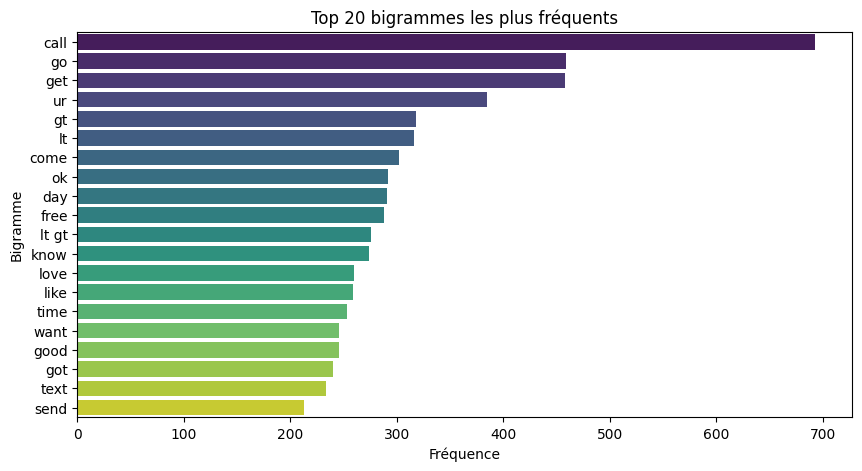

In [23]:
from collections import Counter

X_vector_dense = X_vector.toarray()
terms = vect.get_feature_names_out()

bigram_counts = Counter()
for idx, row in enumerate(X_vector_dense):
    for i, count in enumerate(row):
        if count > 0:
            bigram_counts[terms[i]] += count

top_bigrams = bigram_counts.most_common(20)

bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_df, x='Frequency', y='Bigram', palette='viridis')
plt.title('Top 20 bigrammes les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Bigramme')
plt.show()


- Le graphique montre les 20 bigrammes les plus fréquents dans le corpus textuel.
- **Observation** :
  - Les bigrammes comme "call", "go", "get", et "ur" apparaissent fréquemment.
  - Ces bigrammes reflètent les termes récurrents dans les messages, qu'ils soient `Ham` ou `Spam`.

- **Objectif** :
  - Identifier les associations de mots les plus communes pour mieux comprendre la structure du corpus.


### Division des données en ensembles d'entraînement et de test


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, classe, test_size=0.2, random_state = 0)


In [25]:
list_result_model = []

### Fonction pour tracer les courbes d'apprentissage

In [26]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score de validation")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.title(f"Courbe d'apprentissage - {model_name}")
    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


### Modélisation avec Decision Tree et évaluation des performances


In [27]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
pred_dt = DT.predict(X_test)
score=DT.score(X_test, y_test)
print("score=",DT.score(X_test, y_test))


score= 0.9775784753363229


In [28]:
list_result_model.append(["Decision Tree Classification",score*100.0])

In [29]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       949
           1       0.96      0.89      0.92       166

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



- Une précision globale de **98%**.
- Le modèle montre de très bonnes performances pour la classe majoritaire (0), mais un rappel légèrement plus faible pour la classe minoritaire (1).

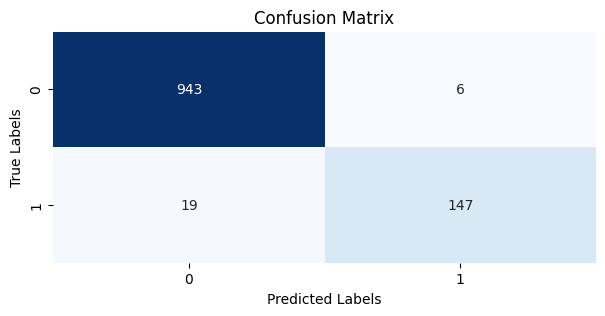

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(y_test, pred_dt)

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


- **943** prédictions correctes pour la classe `0` (True Negatives).
- **147** prédictions correctes pour la classe `1` (True Positives).
- **6** faux positifs (classe `0` mal classée en `1`).
- **19** faux négatifs (classe `1` mal classée en `0`).


- Le modèle performe bien pour la classe majoritaire (`0`) mais fait quelques erreurs sur la classe minoritaire (`1`), comme indiqué par les faux négatifs et faux positifs.

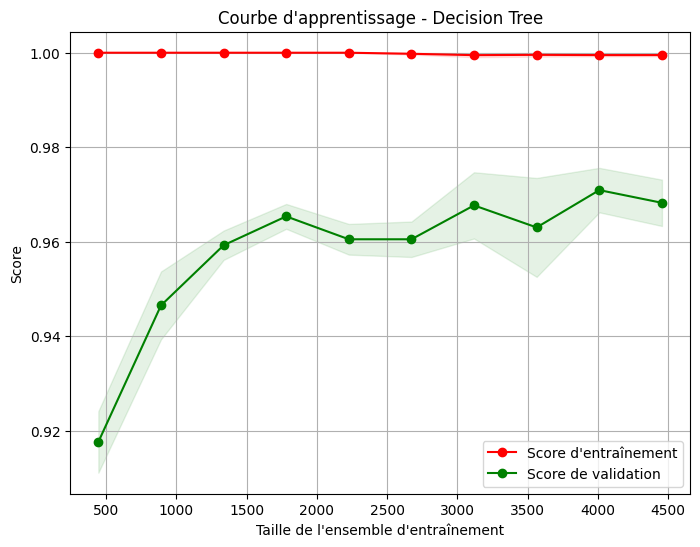

In [31]:
plot_learning_curve(DT, X_vector, classe, "Decision Tree")

- **Observation** :
  - Le score d'entraînement reste élevé (proche de 100%), indiquant un bon ajustement sur l'ensemble d'entraînement.
  - Le score de validation augmente avec la taille de l'ensemble d'entraînement, se stabilisant autour de **96%**, montrant que le modèle généralise bien.
  - L'écart entre les scores d'entraînement et de validation est réduit, indiquant l'absence de sur-apprentissage (overfitting).

- **Conclusion** :
  - Le modèle `Decision Tree` montre de bonnes performances avec des scores cohérents sur les ensembles d'entraînement et de validation.

### Modélisation avec Gradient Boosting et évaluation des performances


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(X_train, y_train)
pred_gbc = GBC.predict(X_test)
score=GBC.score(X_test, y_test)
print("score=",GBC.score(X_test, y_test))

score= 0.9614349775784753


In [33]:
list_result_model.append(["Gradient Boosting Classifier",score*100.0])

In [34]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       949
           1       0.98      0.76      0.85       166

    accuracy                           0.96      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.96      0.96      0.96      1115



- Le modèle montre de bonnes performances globales, particulièrement sur la classe majoritaire (`0`).
- Le rappel pour la classe minoritaire (`1`) est plus faible, indiquant qu'une partie des instances de cette classe ne sont pas correctement identifiées.

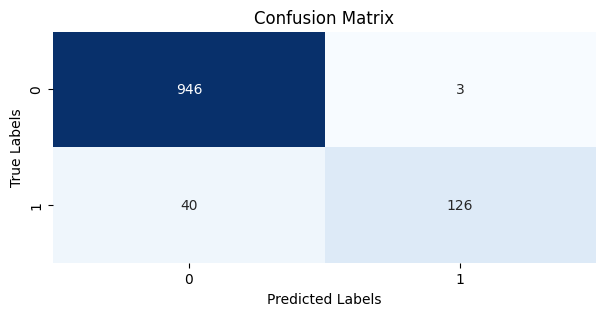

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(y_test, pred_gbc)

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


- **946** : Prédictions correctes pour la classe `0` (True Negatives).
- **126** : Prédictions correctes pour la classe `1` (True Positives).
- **3** : Faux positifs (classe `0` mal classée en `1`).
- **40** : Faux négatifs (classe `1` mal classée en `0`).

- Le modèle performe bien pour la classe majoritaire (`0`) avec peu de faux positifs.
- Les erreurs pour la classe minoritaire (`1`) se manifestent principalement par des faux négatifs.

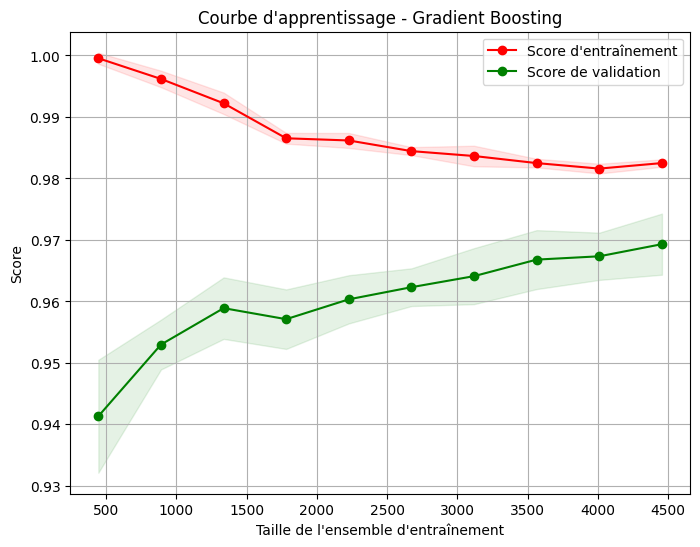

In [36]:
plot_learning_curve(GBC, X_vector, classe, "Gradient Boosting")

- **Observation** :
  - Le score d'entraînement est très élevé au début (proche de 1.00) et diminue légèrement avec l'augmentation de la taille de l'échantillon, montrant un bon ajustement.
  - Le score de validation s'améliore progressivement avec la taille de l'ensemble d'entraînement, se stabilisant autour de **0.97**, indiquant une bonne généralisation.
  - L'écart entre les deux courbes est réduit, ce qui montre que le modèle n'est pas affecté par un sur-apprentissage (overfitting).

- **Conclusion** :
  - Le modèle `Gradient Boosting` montre de bonnes capacités de généralisation et une stabilité dans les performances avec des ensembles de données plus grands.

### Modélisation avec Logistic Regression  et évaluation des performances


In [37]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train)
pred_lr=LR.predict(X_test)
score=LR.score(X_test, y_test)
print("score=",LR.score(X_test, y_test))

score= 0.979372197309417


In [38]:
list_result_model.append(["Logistic Regression",score*100.0])

In [39]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       1.00      0.86      0.93       166

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



- Le modèle montre de très bonnes performances globales, avec une précision et un F1-score élevés pour les deux classes.
- Le rappel pour la classe minoritaire (`1`) est légèrement plus faible, indiquant que quelques exemples de cette classe ne sont pas détectés.

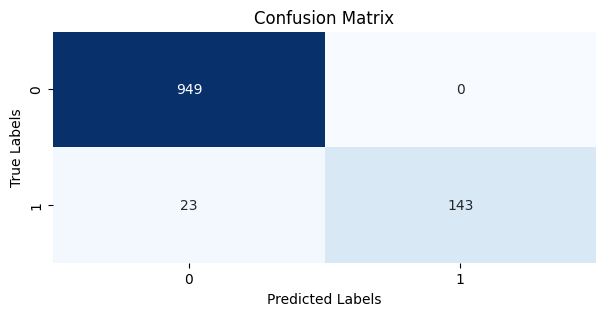

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(y_test, pred_lr)

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


- **949** : Prédictions correctes pour la classe `0` (True Negatives).
- **143** : Prédictions correctes pour la classe `1` (True Positives).
- **0** : Faux positifs (aucune instance de `0` mal classée comme `1`).
- **23** : Faux négatifs (quelques instances de `1` mal classées comme `0`).

- Le modèle performe parfaitement sur la classe majoritaire (`0`) avec 0 faux positifs.
- Quelques erreurs (faux négatifs) pour la classe minoritaire (`1`) sont observées.

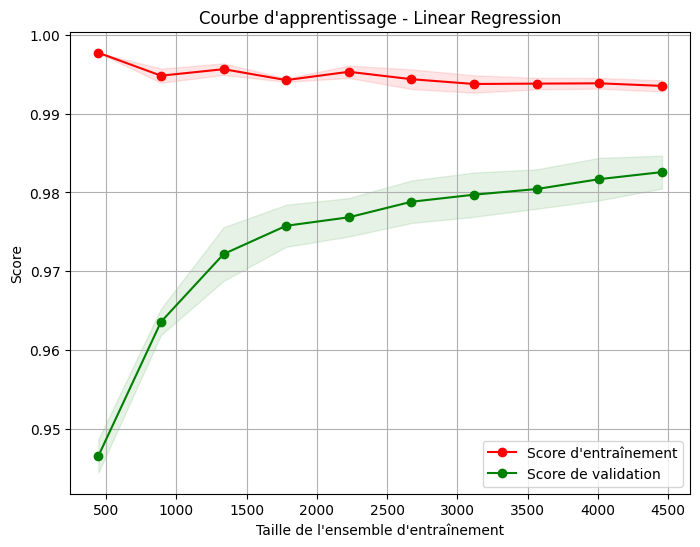

In [41]:
plot_learning_curve(LR, X_vector, classe, "Linear Regression")

- **Observation** :
  - Le score d'entraînement est élevé, légèrement en dessous de 1, ce qui montre que le modèle s'ajuste bien aux données d'entraînement.
  - Le score de validation augmente progressivement avec la taille de l'ensemble d'entraînement et se stabilise autour de **0.98**, indiquant une bonne généralisation.
  - L'écart entre les deux courbes est faible, ce qui montre que le modèle n'est pas affecté par un sur-apprentissage (overfitting).

- **Conclusion** :
  - Le modèle `Logistic Regression` montre de bonnes capacités de généralisation avec une précision élevée et stable sur l'ensemble de validation.

### Modélisation avec Random Forest et évaluation des performances


In [42]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=0)
RFC.fit(X_train, y_train)
pred_rfc = RFC.predict(X_test)
score=RFC.score(X_test, y_test)
print("score=",RFC.score(X_test, y_test))

score= 0.97847533632287


In [43]:
list_result_model.append(["RandomForestClassifier",score*100.0])

In [44]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       0.99      0.86      0.92       166

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



- Le modèle montre de très bonnes performances globales avec des scores élevés pour les deux classes.
- Quelques erreurs sont observées pour la classe minoritaire (`1`), comme indiqué par le rappel de 86%.

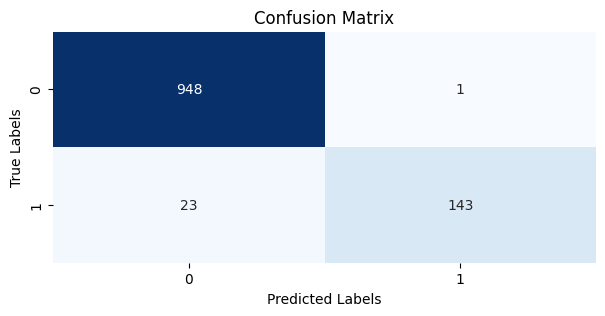

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(y_test, pred_rfc)

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


- **948** : Prédictions correctes pour la classe `0` (True Negatives).
- **143** : Prédictions correctes pour la classe `1` (True Positives).
- **1** : Faux positif (classe `0` mal classée en `1`).
- **23** : Faux négatifs (classe `1` mal classée en `0`).

- Le modèle performe parfaitement pour la classe majoritaire (`0`) avec un seul faux positif.
- Quelques erreurs (faux négatifs) sont observées pour la classe minoritaire (`1`), mais les performances globales restent élevées.

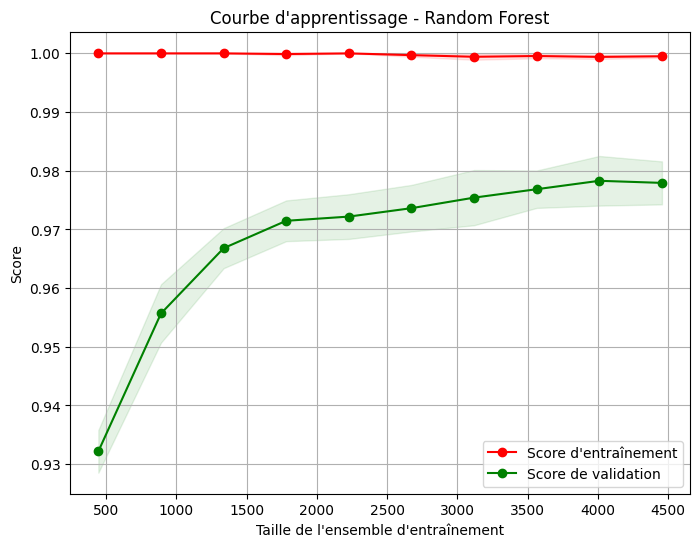

In [46]:
plot_learning_curve(RFC, X_vector, classe, "Random Forest")


- **Observation** :
  - Le score d'entraînement reste très élevé (proche de 1), ce qui indique que le modèle s'ajuste parfaitement aux données d'entraînement.
  - Le score de validation augmente progressivement avec la taille de l'ensemble d'entraînement, atteignant une précision stable autour de **0.98**, indiquant une bonne généralisation.
  - L'écart entre les scores d'entraînement et de validation est faible, suggérant que le modèle n'est pas sur-appris (overfitting) et généralise bien.

- **Conclusion** :
  - Le modèle `Random Forest` montre de très bonnes performances, avec une précision élevée et stable sur les ensembles de validation et d'entraînement.

### Comparaison des performances des modèles


In [47]:
dfb = pd.DataFrame (list_result_model, columns = ['name model', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

In [48]:
dfb.head()

,name model,Accuracy
2,Logistic Regression,97.937220
3,RandomForestClassifier,97.847534
0,Decision Tree Classification,97.757848
1,Gradient Boosting Classifier,96.143498


- Tous les modèles montrent des performances élevées en termes de précision.
- La régression logistique obtient la meilleure précision, suivie de près par le `Random Forest Classifier`.
- Le `Gradient Boosting Classifier` est légèrement moins performant que les autres.

### Tracé des courbes ROC pour les modèles


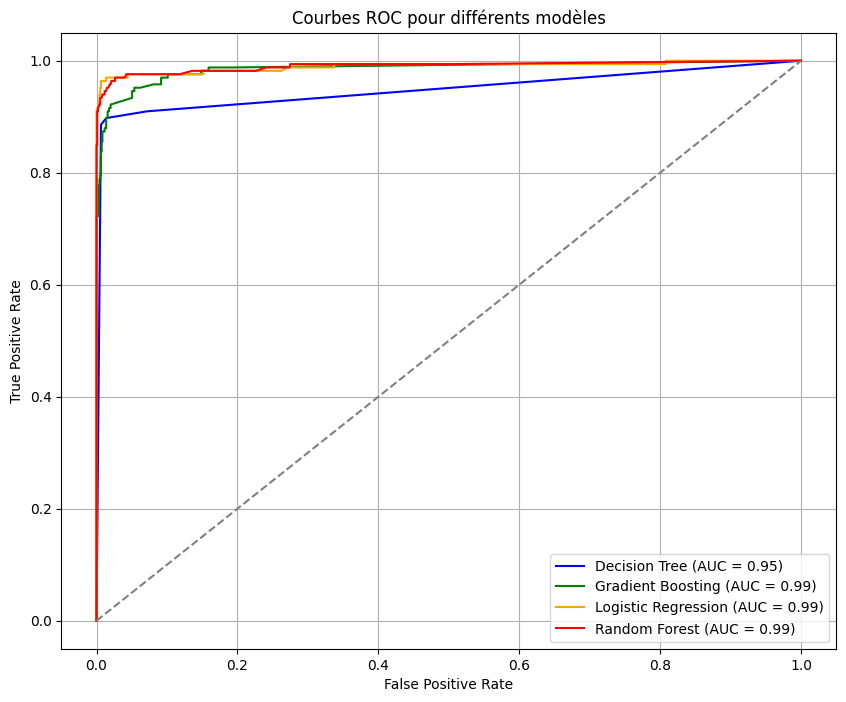

In [50]:
from sklearn.metrics import roc_curve, auc


# Arbre de décision
y_pred_proba_dt = DT.predict_proba(X_test)[:, 1]

# Gradient Boosting
y_pred_proba_gbc = GBC.predict_proba(X_test)[:, 1]

# Régression Logistique
y_pred_proba_lr = LR.predict_proba(X_test)[:, 1]

# Forêt aléatoire
y_pred_proba_rfc = RFC.predict_proba(X_test)[:, 1]




from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Arbre de décision
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", color="blue")

# Gradient Boosting
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
plt.plot(fpr_gbc, tpr_gbc, label=f"Gradient Boosting (AUC = {roc_auc_gbc:.2f})", color="green")

# Régression Logistique
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color="orange")

# Forêt aléatoire
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
plt.plot(fpr_rfc, tpr_rfc, label=f"Random Forest (AUC = {roc_auc_rfc:.2f})", color="red")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

plt.title("Courbes ROC pour différents modèles")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()



- **Decision Tree** : La courbe est en dessous des autres avec une AUC de 0.95, montrant une capacité de discrimination plus faible.
- **Gradient Boosting, Logistic Regression, et Random Forest** : Ces modèles ont des courbes similaires, proches du coin supérieur gauche, avec une AUC de 0.99, indiquant une excellente capacité à distinguer les classes.
- **Observation globale** : Les trois derniers modèles surperforment le `Decision Tree`, et montrent des performances quasi identiques, ce qui les rend tous adaptés pour cette tâche.


### Tracé des courbes de précision-rappel pour les modèles


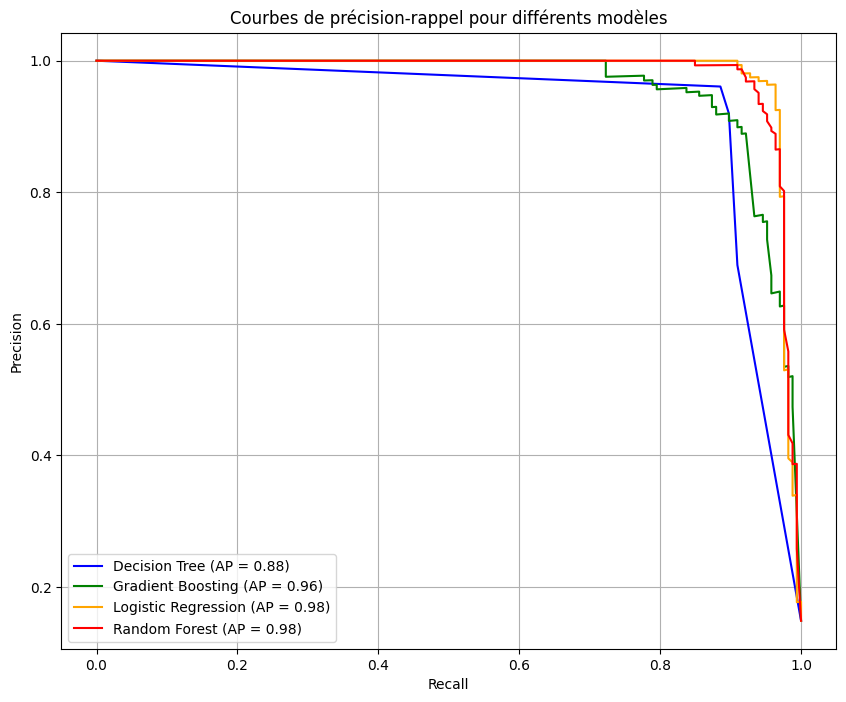

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# Arbre de décision
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
avg_precision_dt = average_precision_score(y_test, y_pred_proba_dt)
plt.plot(recall_dt, precision_dt, label=f"Decision Tree (AP = {avg_precision_dt:.2f})", color="blue")

# Gradient Boosting
precision_gbc, recall_gbc, _ = precision_recall_curve(y_test, y_pred_proba_gbc)
avg_precision_gbc = average_precision_score(y_test, y_pred_proba_gbc)
plt.plot(recall_gbc, precision_gbc, label=f"Gradient Boosting (AP = {avg_precision_gbc:.2f})", color="green")

# Régression Logistique
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
avg_precision_lr = average_precision_score(y_test, y_pred_proba_lr)
plt.plot(recall_lr, precision_lr, label=f"Logistic Regression (AP = {avg_precision_lr:.2f})", color="orange")

# Forêt aléatoire
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_pred_proba_rfc)
avg_precision_rfc = average_precision_score(y_test, y_pred_proba_rfc)
plt.plot(recall_rfc, precision_rfc, label=f"Random Forest (AP = {avg_precision_rfc:.2f})", color="red")

plt.title("Courbes de précision-rappel pour différents modèles")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()


- **Decision Tree** : La courbe est en dessous des autres, avec une moyenne de précision (AP) de **0.88**, montrant des performances plus faibles, notamment pour des rappels élevés.

- **Gradient Boosting, Logistic Regression, et Random Forest** :
  - Les courbes sont proches du coin supérieur droit, avec des AP élevées :
    - Gradient Boosting : **0.96**
    - Logistic Regression : **0.98**
    - Random Forest : **0.98**
  - Ces modèles maintiennent une précision élevée même avec des rappels importants.

- **Conclusion** : 
  - Les trois derniers modèles surpassent le `Decision Tree`, offrant de meilleures performances globales pour gérer la classe minoritaire.

### Calcul des scores AUC, F1-Score et comparaison des performances des modèles

In [65]:
from sklearn.metrics import roc_auc_score

auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
auc_gbc = roc_auc_score(y_test, y_pred_proba_gbc)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

print("AUC - Decision Tree:", auc_dt)
print("AUC - Gradient Boosting:", auc_gbc)
print("AUC - Logistic Regression:", auc_lr)
print("AUC - Random Forest:", auc_rfc)


AUC - Decision Tree: 0.9510137494128251
AUC - Gradient Boosting: 0.9859395432097198
AUC - Logistic Regression: 0.9899958104282249
AUC - Random Forest: 0.9906432897025403


- **Decision Tree** : AUC = **0.95**. Ce modèle montre une capacité correcte à distinguer les classes, mais est moins performant que les autres modèles.

- **Gradient Boosting** : AUC = **0.99**. Ce modèle offre une excellente capacité de discrimination entre les classes.

- **Logistic Regression** : AUC = **0.99**. Performances similaires à celles du Gradient Boosting, avec une capacité remarquable à séparer les classes.

- **Random Forest** : AUC = **0.99**. Légèrement supérieur, il est le modèle le plus performant en termes de discrimination entre les classes.


In [67]:
list_result_model = [
    ["Decision Tree", accuracy_score(y_test, pred_dt), auc_dt, classification_report(y_test, pred_dt, output_dict=True)['1']['f1-score']],
    ["Gradient Boosting", accuracy_score(y_test, pred_gbc), auc_gbc, classification_report(y_test, pred_gbc, output_dict=True)['1']['f1-score']],
    ["Logistic Regression", accuracy_score(y_test, pred_lr), auc_lr, classification_report(y_test, pred_lr, output_dict=True)['1']['f1-score']],
    ["Random Forest", accuracy_score(y_test, pred_rfc), auc_rfc, classification_report(y_test, pred_rfc, output_dict=True)['1']['f1-score']]
]

df_metrics = pd.DataFrame(list_result_model, columns=["Model", "Accuracy", "AUC", "F1-Score"])
df_metrics


,Model,Accuracy,AUC,F1-Score
0,Decision Tree,0.978475,0.951014,0.925466
1,Gradient Boosting,0.961435,0.985940,0.854237
2,Logistic Regression,0.979372,0.989996,0.925566
3,Random Forest,0.978475,0.990643,0.922581


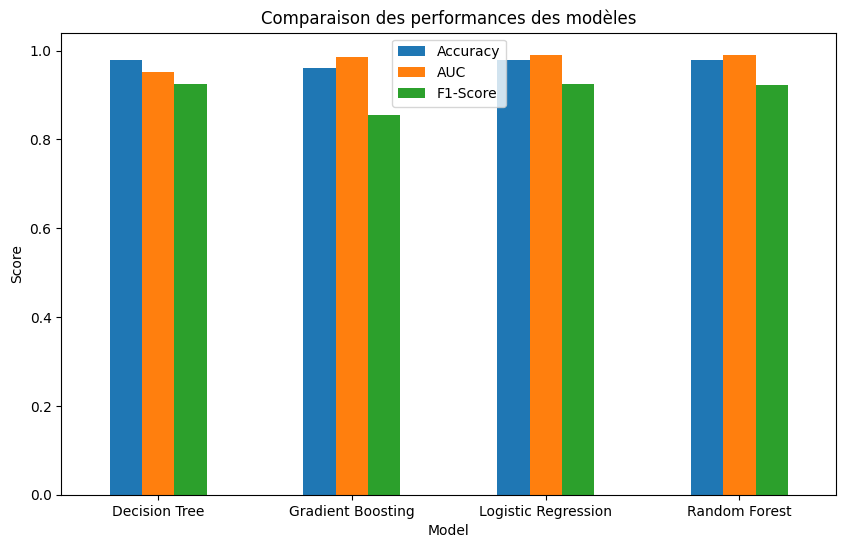

In [68]:
df_metrics.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title("Comparaison des performances des modèles")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="best")
plt.show()


Le graphique compare les performances des différents modèles (`Decision Tree`, `Gradient Boosting`, `Logistic Regression`, et `Random Forest`) à travers trois métriques : 

- **Accuracy** : Précision globale du modèle.
- **AUC** : Capacité à discriminer entre les classes.
- **F1-Score** : Équilibre entre précision et rappel.

Chaque barre représente le score d'un modèle pour une métrique donnée.


### Analyse des performances des modèles

- **Logistic Regression** et **Random Forest** : Meilleures performances globales avec des scores élevés pour toutes les métriques.
- **Gradient Boosting** : Bonne AUC (0.99) mais un F1-Score légèrement plus bas.
- **Decision Tree** : Performances correctes mais légèrement inférieures aux autres modèles.

- **Conclusion** : Logistic Regression et Random Forest sont les plus équilibrés.


## Conclusion finale

Parmi les modèles évalués, **Logistic Regression** et **Random Forest** se distinguent par leurs performances globales équilibrées sur toutes les métriques (Accuracy, AUC, et F1-Score). Ces modèles sont particulièrement adaptés pour cette tâche, offrant à la fois une précision élevée et une excellente capacité de discrimination entre les classes.

**Gradient Boosting** montre également de bonnes performances, mais avec un F1-Score légèrement inférieur, tandis que le **Decision Tree** reste le moins performant, bien qu'il atteigne des résultats acceptables. 

En conclusion, **Logistic Regression** et **Random Forest** sont les choix recommandés pour cette classification.
